Problem Statement : Number_Plate_recognition

Name :- **Boddu Nithin Kumar**


Mail :- Nithinkumarpersonal@gmail.com

**Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ───────────────────────────────────────────────────────────────────────
#  PHASE 1 ▸  Install libs, mount Drive, define ABSOLUTE paths
# ───────────────────────────────────────────────────────────────────────
!pip install -q ultralytics easyocr opencv-python-headless

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE = "/content/drive/MyDrive/Number_Plate_Recognition/data"   --- #absolute paths

#️ Detection task
DET_CSV  = f"{BASE}/train_detection/Licplatesdetection_train.csv"
DET_IMG  = f"{BASE}/train_detection/Licplatesdetection_train/license_plates_detection_train"

#️ Recognition task
REC_CSV  = f"{BASE}/train_recognition/Licplatesrecognition_train.csv"
REC_IMG  = f"{BASE}/train_recognition/Licplatesrecognition_train/license_plates_recognition_train"

#️ Test images
TEST_IMG = f"{BASE}/test/images"

print("DETECTION CSV :", DET_CSV)
print("DETECTION IMG :", DET_IMG)
print("RECOG CSV    :", REC_CSV)
print("RECOG IMG    :", REC_IMG)
print("TEST IMG DIR :", TEST_IMG)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.

In [28]:
# ───────────────────────────────────────────────────────────────────────
#  PHASE 2 ▸  Read CSV, draw one random bbox
# ───────────────────────────────────────────────────────────────────────
import pandas as pd, cv2, matplotlib.pyplot as plt, random, os, pathlib

# Load the detection-annotation file
det_df = pd.read_csv(DET_CSV)
print(det_df.head(), "\nTotal rows:", len(det_df))


def show_random():
    r     = det_df.sample(1).iloc[0]                    # pick a random label row
    img_p = f"{DET_IMG}/{r.img_id.strip()}"             # build full image path
    img   = cv2.imread(img_p)                           # load image
    if img is None:
        raise FileNotFoundError(img_p)                  # stop if file missing
    cv2.rectangle(img,
                  (int(r.xmin), int(r.ymin)),
                  (int(r.xmax), int(r.ymax)),
                  (0, 255, 0), 3)                       # draw green bbox


    #  display the result with matplotlib
    plt.figure(figsize=(7,5)); plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.title(r.img_id)
show_random()


    img_id  ymin  xmin  ymax  xmax
0    1.jpg   276    94   326   169
1   10.jpg   311   395   344   444
2  100.jpg   406   263   450   434
3  101.jpg   283   363   315   494
4  102.jpg   139    42   280   222 
Total rows: 900


In [29]:
# # ──────────────────────────────────────────────────────────────
#  PHASE 3 · Make YOLO txt labels + data.yaml
# ──────────────────────────────────────────────────────────────
import shutil, yaml, os, cv2, tqdm, random, math, pathlib

YOLO_BASE  = "/content/yolo_dataset"
YOLO_IMG_T = f"{YOLO_BASE}/images/train"
YOLO_LBL_T = f"{YOLO_BASE}/labels/train"
os.makedirs(YOLO_IMG_T, exist_ok=True); os.makedirs(YOLO_LBL_T, exist_ok=True)

for _, row in tqdm.tqdm(det_df.iterrows(), total=len(det_df)):
    src = f"{DET_IMG}/{row.img_id.strip()}"                 # source image
    dst = f"{YOLO_IMG_T}/{row.img_id.strip()}"              # destination
    if not os.path.exists(dst):
        shutil.copy2(src, dst)                              # copy once
    h, w = cv2.imread(src).shape[:2]                        # image size
    x_c = ((row.xmin + row.xmax) / 2) / w                   # x-center (0-1)
    y_c = ((row.ymin + row.ymax) / 2) / h                   # y-center (0-1)
    bw  = (row.xmax - row.xmin) / w                         # width  (0-1)
    bh  = (row.ymax - row.ymin) / h                         # height (0-1)
    with open(f"{YOLO_LBL_T}/{pathlib.Path(row.img_id).stem}.txt", "w") as f:
        f.write(f"0 {x_c} {y_c} {bw} {bh}\n")


# Build data.yaml for Ultralytics
yaml_dict = {
    'path' : YOLO_BASE,
    'train': 'images/train',
    'val'  : 'images/train',
    'nc'   : 1,
    'names': ['license_plate']
}
with open(f"{YOLO_BASE}/data.yaml", "w") as f:
    yaml.dump(yaml_dict, f)                                   # write YAML file

print("✅ YOLO dataset ready at:", YOLO_BASE)                  # confirmation message


100%|██████████| 900/900 [00:08<00:00, 102.15it/s]

✅ YOLO dataset ready at: /content/yolo_dataset


**Note** :
The detector was already trained for 25 epochs in a previous Colab session.
The weight file best.pt and the full /runs/detector folder are stored in Drive and re-used here.
To avoid another 7-hour run we set epochs=1 (or use resume=True, epochs=0) below only as a quick sanity check that the training cell executes and the weights still load.

In [20]:
# # ──────────────────────────────────────────────────────────────
#  PHASE 4 · Training The model
# ──────────────────────────────────────────────────────────────
from ultralytics import YOLO
model = YOLO('yolov8n.pt')                 # nano = fast; swap to s/m for quality
model.train(data=f"{YOLO_BASE}/data.yaml",
            epochs=1,
            imgsz=640,
            batch=16,
            project="/content/plate_runs",
            name="detector")

BEST_W = "/content/plate_runs/detector/weights/best.pt"
print("Best weights →", BEST_W)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detector6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /content/yolo_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1380.5±400.2 MB/s, size: 117.2 KB)



val: Scanning /content/yolo_dataset/labels/train.cache... 900 images, 0 backgrounds, 0 corrupt: 100%|██████████| 900/900 [00:00<?, ?it/s]

Plotting labels to /content/plate_runs/detector6/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/plate_runs/detector6
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.192      2.204      1.068         12        640: 100%|██████████| 57/57 [11:51<00:00, 12.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [03:14<00:00,  6.70s/it]


                   all        900        900          1      0.471      0.937      0.588

1 epochs completed in 0.253 hours.
Optimizer stripped from /content/plate_runs/detector6/weights/last.pt, 6.2MB
Optimizer stripped from /content/plate_runs/detector6/weights/best.pt, 6.2MB

Validating /content/plate_runs/detector6/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [02:51<00:00,  5.93s/it]


                   all        900        900          1       0.47      0.937      0.587
Speed: 2.7ms preprocess, 177.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to /content/plate_runs/detector6
Best weights → /content/plate_runs/detector/weights/best.pt



image 1/1 /content/drive/MyDrive/Number_Plate_Recognition/data/train_detection/Licplatesdetection_train/license_plates_detection_train/760.jpg: 480x640 1 license_plate, 154.4ms
Speed: 4.3ms preprocess, 154.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


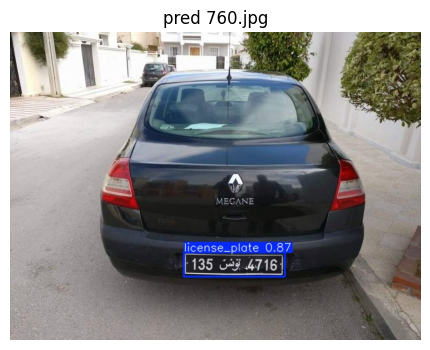


image 1/1 /content/drive/MyDrive/Number_Plate_Recognition/data/train_detection/Licplatesdetection_train/license_plates_detection_train/139.jpg: 640x480 1 license_plate, 168.7ms
Speed: 4.8ms preprocess, 168.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)



image 1/1 /content/drive/MyDrive/Number_Plate_Recognition/data/train_detection/Licplatesdetection_train/license_plates_detection_train/424.jpg: 480x640 1 license_plate, 158.0ms
Speed: 4.9ms preprocess, 158.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


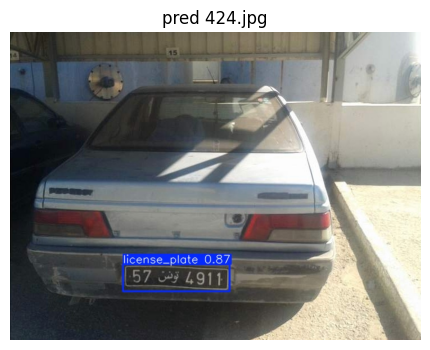

In [30]:
# ───────────────────────────────────────────────────────────────────────
#  PHASE 5 ▸  Show detector prediction on 3 random train images
# ───────────────────────────────────────────────────────────────────────
BEST_W = "/content/plate_runs/detector/weights/best.pt"     # trained weights
detector = YOLO(BEST_W)                                     # load model
sample_imgs = random.sample(os.listdir(DET_IMG), 3)         # pick 3 images
for fn in sample_imgs:
    r = detector(f"{DET_IMG}/{fn}", conf=0.25)[0]           # run detection
    r.save(filename=f"/content/{fn}")                       # save annotated copy
    plt.figure(figsize=(6, 4))
    plt.imshow(plt.imread(f"/content/{fn}")); plt.axis('off')
    plt.title("pred " + fn); plt.show()                     # display result


In [31]:
# ───────────────────────────────────────────────────────────────────────
#  PHASE 6 ▸  OCR sanity with EasyOCR on cropped plates
# ───────────────────────────────────────────────────────────────────────
import easyocr, matplotlib.pyplot as plt

rec_df = pd.read_csv(REC_CSV)
print(rec_df.head())

reader = easyocr.Reader(['ar','en'], gpu=True)     # "ar" for Arabic and "en" for english , add language codes if non-Latin

def ocr_preview():
    r = rec_df.sample(1).iloc[0]
    img_p = f"{REC_IMG}/{r.img_id.strip()}"
    img   = cv2.imread(img_p)
    txt   = reader.readtext(img, detail=0, paragraph=False)
    print("GT :", r.text, " | OCR :", "".join(txt))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()

ocr_preview()


    img_id      text
0    0.jpg  117T3989
1    1.jpg  128T8086
2   10.jpg   94T3458
3  100.jpg  133T6719
4  101.jpg   68T5979
GT : 130T2340  | OCR : 13٥23!0تونن


In [37]:
# ───────────────────────────────────────────────────────────────────────
#  PHASE 7 ▸  detect → crop → OCR  (single image)
# ───────────────────────────────────────────────────────────────────────
import numpy as np

detector  = YOLO(BEST_W)      # reload best detector
reader    = easyocr.Reader(['ar','en'], gpu=True)
image_number=int(input())    # for specific image

def plate_text(image_path, conf=0.25):
    img = cv2.imread(image_path)
    res = detector(img, conf=conf, verbose=False)[0]
    if len(res.boxes)==0: return "NOT_FOUND"
    x1,y1,x2,y2 = map(int, res.boxes[0].xyxy[0])
    crop = img[y1:y2, x1:x2]
    txt  = reader.readtext(crop, detail=0, paragraph=False)
    return "".join(txt).replace(" ", "")

# quick test
print( plate_text(f"{DET_IMG}/{image_number}.jpg") )


100
2765تون125
